<a href="https://colab.research.google.com/github/snehaskarun22-lang/DS-LAB7/blob/main/ISL_Static_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mediapipe

In [ ]:
import os
import glob
import cv2
import numpy as np
import mediapipe as mp
import time

# --- 1. Setup MediaPipe (MODIFIED FOR 2 HANDS) ---
print("Initializing MediaPipe Hands model (for 2 hands)...")
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=True,  # We are processing static images
    max_num_hands=2,         # <--- MODIFIED: Now detects 2 hands
    min_detection_confidence=0.5
)
mp_drawing = mp.solutions.drawing_utils # For visualization (optional)

# --- 2. Landmark Extraction & Normalization Function (MODIFIED FOR 2 HANDS) ---
def extract_2hand_landmarks(image, model):
    """
    Extracts 126 landmarks (2 hands * 21 * 3) from a single image frame.
    Returns a flattened, *normalized* NumPy array of size 126.
    Slots 0-62 are for the Left Hand.
    Slots 63-125 are for the Right Hand.
    """
    # Create an empty array for all 126 features
    # (2 hands * 21 landmarks * 3 coordinates)
    landmarks_array = np.zeros(2 * 21 * 3)

    # Convert BGR (OpenCV) to RGB (MediaPipe)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_rgb.flags.writeable = False

    # Process the image
    results = model.process(image_rgb)

    # Check if any hands were detected
    if not results.multi_hand_landmarks:
        return None  # Return None if no hands are found

    # Loop through all detected hands
    for hand_index, hand_landmarks in enumerate(results.multi_hand_landmarks):

        # Get the hand label ("Left" or "Right")
        # This label is from the *user's* perspective (the person in the image)
        try:
            hand_label = results.multi_handedness[hand_index].classification[0].label
        except Exception as e:
            # Fallback if label is not found (should be rare)
            print(f"Warning: Could not determine hand label: {e}")
            continue # Skip this hand

        # --- Normalization (relative to each hand's *own* wrist) ---
        landmarks = []
        wrist_x, wrist_y, wrist_z = hand_landmarks.landmark[0].x, hand_landmarks.landmark[0].y, hand_landmarks.landmark[0].z

        for lm in hand_landmarks.landmark:
            landmarks.append(lm.x - wrist_x)
            landmarks.append(lm.y - wrist_y)
            landmarks.append(lm.z - wrist_z)

        # Convert to a flat array of 63 features
        flat_landmarks = np.array(landmarks).flatten()

        # --- Fill the correct slots in our 126-feature array ---
        if hand_label == "Left":
            landmarks_array[0:63] = flat_landmarks  # First 63 slots
        elif hand_label == "Right":
            landmarks_array[63:126] = flat_landmarks # Second 63 slots

    return landmarks_array

# --- 3. Setup Paths ---
DRIVE_PATH = '/content/drive/MyDrive'
DATA_PATH = os.path.join(DRIVE_PATH, 'ISL_Static_Data')  # Your Kaggle images
# --- MODIFIED: New output folder for 2-hand data ---
FEATURES_PATH = os.path.join(DRIVE_PATH, 'ISL_Static_2Hand_Features')

os.makedirs(FEATURES_PATH, exist_ok=True)

# --- 4. Main Processing Loop (No changes needed here) ---
print(f"Starting 2-HAND feature extraction from: {DATA_PATH}")
print(f"Saving features to: {FEATURES_PATH}")

try:
    action_folders = sorted(os.listdir(DATA_PATH))
    total_start_time = time.time()

    total_files_processed = 0
    total_hands_not_detected = 0

    for action in action_folders:
        action_path = os.path.join(DATA_PATH, action)
        if not os.path.isdir(action_path):
            continue

        print(f"\nProcessing action: '{action}'")
        features_action_path = os.path.join(FEATURES_PATH, action)
        os.makedirs(features_action_path, exist_ok=True)

        image_extensions = ['*.jpg', '*.png', '*.jpeg']
        media_files = []
        for ext in image_extensions:
            media_files.extend(glob.glob(os.path.join(action_path, ext)))

        if not media_files:
            print(f"  No image files found for '{action}'.")
            continue

        file_count = 0
        for media_path in media_files:
            file_name = os.path.basename(media_path)
            file_base = os.path.splitext(file_name)[0]
            save_path = os.path.join(features_action_path, f"{file_base}.npy")

            try:
                frame = cv2.imread(media_path)
                if frame is not None:
                    # --- Use the new 2-hand extraction function ---
                    landmarks = extract_2hand_landmarks(frame, hands)

                    if landmarks is not None:
                        # Save the 126 features
                        np.save(save_path, landmarks)
                        file_count += 1
                    else:
                        print(f"  - No hand(s) detected in {file_name}")
                        total_hands_not_detected += 1
                else:
                    print(f"  - Error reading image: {file_name}")

            except Exception as e:
                print(f"  - FAILED to process {file_name}: {e}")

        print(f"  Finished '{action}', processed {file_count} files.")
        total_files_processed += file_count

    total_time = time.time() - total_start_time
    print(f"\n--- Feature Extraction Complete ---")
    print(f"Total time: {total_time:.2f} seconds")
    print(f"Total files successfully processed: {total_files_processed}")
    print(f"Total files where no hands were detected: {total_hands_not_detected}")
    print(f"All features saved in: {FEATURES_PATH}")

except FileNotFoundError:
    print(f"Error: The directory '{DATA_PATH}' was not found.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

finally:
    # Release the hands model
    hands.close()
    print("MediaPipe Hands model released.")

Streaming output truncated to the last 5000 lines.
  - No hand(s) detected in 136.jpg
  - No hand(s) detected in 11.jpg
  - No hand(s) detected in 117.jpg
  - No hand(s) detected in 149.jpg
  - No hand(s) detected in 20.jpg
  - No hand(s) detected in 109.jpg
  - No hand(s) detected in 12.jpg
  - No hand(s) detected in 14.jpg
  - No hand(s) detected in 120.jpg
  - No hand(s) detected in 13.jpg
  - No hand(s) detected in 125.jpg
  - No hand(s) detected in 112.jpg
  - No hand(s) detected in 123.jpg
  - No hand(s) detected in 16.jpg
  - No hand(s) detected in 138.jpg
  - No hand(s) detected in 116.jpg
  - No hand(s) detected in 110.jpg
  - No hand(s) detected in 18.jpg
  - No hand(s) detected in 128.jpg
  - No hand(s) detected in 17.jpg
  - No hand(s) detected in 2.jpg
  - No hand(s) detected in 140.jpg
  - No hand(s) detected in 118.jpg
  - No hand(s) detected in 126.jpg
  - No hand(s) detected in 121.jpg
  - No hand(s) detected in 107.jpg
  - No hand(s) detected in 426.jpg
  - No hand(s)

In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# --- 1. Setup Paths and Constants ---
DRIVE_PATH = '/content/drive/MyDrive'
# --- MODIFIED: Load from our new 2-hand folder ---
FEATURES_PATH = os.path.join(DRIVE_PATH, 'ISL_Static_2Hand_Features')

# --- MODIFIED: Save new model files ---
STATIC_MODEL_SAVE_PATH = os.path.join(DRIVE_PATH, 'isl_static_2hand_model.keras')
STATIC_LABELS_SAVE_PATH = os.path.join(DRIVE_PATH, 'isl_static_2hand_labels.npy')

# --- MODIFIED: The most important change! ---
# 2 hands * 21 landmarks * 3 coordinates = 126 features
NUM_FEATURES = 126

# --- 2. Load and Filter Data ---
print("Loading 2-Hand feature data...")

X = []
labels = []

try:
    action_folders = sorted(os.listdir(FEATURES_PATH))
    if not action_folders:
        print(f"No feature folders found in {FEATURES_PATH}.")
except FileNotFoundError:
    print(f"Error: The directory '{FEATURES_PATH}' was not found.")
    print("This folder should have been created by 'extract_2hand_features.py'.")

if 'action_folders' in locals():
    for action in action_folders:
        action_path = os.path.join(FEATURES_PATH, action)
        npy_files = glob.glob(os.path.join(action_path, '*.npy'))

        for npy_file in npy_files:
            data = np.load(npy_file)

            # --- Check for the correct shape ---
            if data.shape == (NUM_FEATURES,):
                X.append(data)
                labels.append(action)
            else:
                print(f"Skipping malformed file (wrong shape): {npy_file}")


    if not X:
        print("No static image data was found. Cannot proceed.")
    else:
        print(f"Successfully loaded {len(X)} static images for {len(np.unique(labels))} actions.")

        # --- 3. Preprocess Data ---
        X = np.array(X)

        # Encode text labels to numbers
        le = LabelEncoder()
        y_encoded = le.fit_transform(labels)

        # One-hot encode the numerical labels
        y = to_categorical(y_encoded)

        # Save the encoder and labels for later use
        np.save(STATIC_LABELS_SAVE_PATH, le.classes_)
        print(f"Saved static label mapping: {list(le.classes_)}")

        # --- 4. Split Data ---
        # We use 20% of the data for testing
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        print(f"Data shapes: X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")

        # --- 5. Build the Static Model (MODIFIED for 126 features) ---
        num_static_actions = len(le.classes_)

        model = Sequential()
        # --- MODIFIED: Input shape is now 126 ---
        model.add(Input(shape=(NUM_FEATURES,)))
        model.add(Dense(128, activation='relu')) # Start with a bigger layer
        model.add(Dropout(0.3))
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.4))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(num_static_actions, activation='softmax')) # Output layer

        model.summary()

        # --- 6. Compile and Train ---
        model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

        print("--- Starting Static Model Training ---")

        history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)

        print("--- Static Model Training Complete ---")

        # --- 7. Save the Model ---
        model.save(STATIC_MODEL_SAVE_PATH)
        print(f"Static 2-Hand model saved successfully to {STATIC_MODEL_SAVE_PATH}")

Loading 2-Hand feature data...
Successfully loaded 22854 static images for 36 actions.
Saved static label mapping: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Data shapes: X_train: (18283, 126), y_train: (18283, 36), X_test: (4571, 126), y_test: (4571, 36)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        16,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,820 (339.14 KB)

 Trainable params: 86,820 (339.14 KB)

 Non-trainable params: 0 (0.00 B)

--- Starting Static Model Training ---
Epoch 1/100
572/572 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.3265 - loss: 2.2691 - val_accuracy: 0.8182 - val_loss: 0.5672
Epoch 2/100
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7671 - loss: 0.6849 - val_accuracy: 0.8558 - val_loss: 0.3753
Epoch 3/100
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8256 - loss: 0.5040 - val_accuracy: 0.8950 - val_loss: 0.2874
Epoch 4/100
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8513 - loss: 0.4188 - val_accuracy: 0.9053 - val_loss: 0.2528
Epoch 5/100
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8732 - loss: 0.3639 - val_accuracy: 0.9306 - val_loss: 0.2332
Epoch 6/100
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8808 - loss: 0.3462 - val_accuracy: 0.9337 - val_loss: 0.1987
Epoch 7/100
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8940 - loss: 0.3019 - val_accuracy: 0.9355 - val_loss: 0.1861
Epoch 8/100
572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - acc

--- Starting Evaluation Script ---
Loading 2-Hand feature data...
Successfully loaded 22854 total samples.
Re-creating training/test split...
Test set created successfully with 4571 samples.
Loading model from: /content/drive/MyDrive/isl_static_2hand_model.keras
Model loaded successfully.
Loading labels from: /content/drive/MyDrive/isl_static_2hand_labels.npy
Labels loaded successfully.


--- Starting Model Evaluation on Test Set ---
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        93
           1       0.99      1.00      0.99       136
           2       1.00      0.98      0.99       126
           3       1.00      1.00      1.00       141
           4       1.00      1.00      1.00       107
           5       0.99      1.00      1.00       153
           6       1.00      1.00      1.00        97
           7       1.00      1.00      1.00       111
   

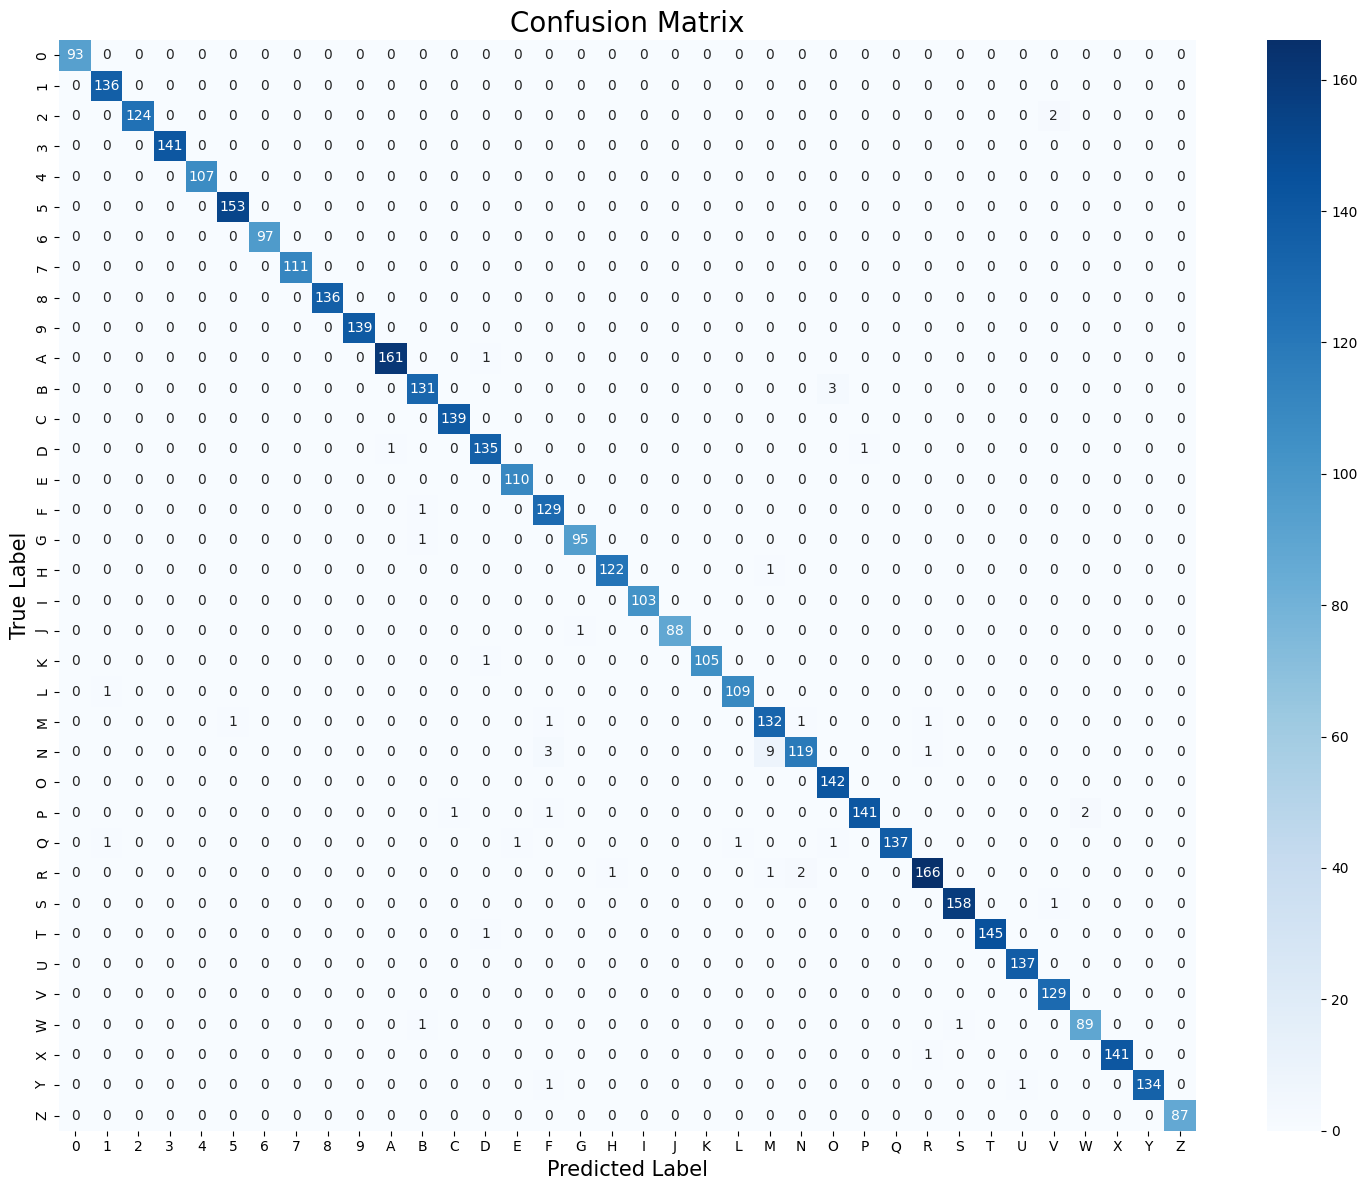


--- Evaluation Complete ---


In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Setup Paths and Constants ---
print("--- Starting Evaluation Script ---")
DRIVE_PATH = '/content/drive/MyDrive'
FEATURES_PATH = os.path.join(DRIVE_PATH, 'ISL_Static_2Hand_Features')
STATIC_MODEL_SAVE_PATH = os.path.join(DRIVE_PATH, 'isl_static_2hand_model.keras')
STATIC_LABELS_SAVE_PATH = os.path.join(DRIVE_PATH, 'isl_static_2hand_labels.npy')
CONFUSION_MATRIX_PLOT_PATH = os.path.join(DRIVE_PATH, 'confusion_matrix_2hand.png')

NUM_FEATURES = 126

# --- 2. Load the *ENTIRE* Dataset (We need to re-create the test set) ---
print("Loading 2-Hand feature data...")
X = []
labels = []

try:
    action_folders = sorted(os.listdir(FEATURES_PATH))
    if not action_folders:
        print(f"No feature folders found in {FEATURES_PATH}.")
except FileNotFoundError:
    print(f"Error: The directory '{FEATURES_PATH}' was not found.")

if 'action_folders' in locals():
    for action in action_folders:
        action_path = os.path.join(FEATURES_PATH, action)
        npy_files = glob.glob(os.path.join(action_path, '*.npy'))

        for npy_file in npy_files:
            data = np.load(npy_file)
            if data.shape == (NUM_FEATURES,):
                X.append(data)
                labels.append(action)
            else:
                print(f"Skipping malformed file (wrong shape): {npy_file}")

    if not X:
        print("No static image data was found. Cannot proceed.")
    else:
        print(f"Successfully loaded {len(X)} total samples.")

        # --- 3. Preprocess Data (Same as training script) ---
        X = np.array(X)
        le = LabelEncoder()
        y_encoded = le.fit_transform(labels)
        y = to_categorical(y_encoded)

        # We MUST use the same split as the training script
        print("Re-creating training/test split...")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        print(f"Test set created successfully with {len(X_test)} samples.")

        # --- 4. Load the Trained Model and Labels ---
        try:
            print(f"Loading model from: {STATIC_MODEL_SAVE_PATH}")
            model = load_model(STATIC_MODEL_SAVE_PATH)
            print("Model loaded successfully.")

            print(f"Loading labels from: {STATIC_LABELS_SAVE_PATH}")
            class_names = np.load(STATIC_LABELS_SAVE_PATH)
            print("Labels loaded successfully.")

        except Exception as e:
            print(f"Error loading model or labels: {e}")
            print("Please make sure the model and label files exist before running evaluation.")
            exit()

        # --- 5. Run Evaluation ---
        print("\n\n--- Starting Model Evaluation on Test Set ---")

        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_test_classes = np.argmax(y_test, axis=1)

        # --- 6. Print Classification Report ---
        print("\n--- Classification Report ---")
        print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

        # --- 7. Generate and Plot Confusion Matrix ---
        print("\n--- Generating Confusion Matrix ---")

        cm = confusion_matrix(y_test_classes, y_pred_classes)

        plt.figure(figsize=(15, 12))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix', fontsize=20)
        plt.ylabel('True Label', fontsize=15)
        plt.xlabel('Predicted Label', fontsize=15)
        plt.tight_layout()

        plt.savefig(CONFUSION_MATRIX_PLOT_PATH)
        print(f"Confusion matrix plot saved to: {CONFUSION_MATRIX_PLOT_PATH}")

        plt.show()
        print("\n--- Evaluation Complete ---")